In [1]:
import execute_tensor as execute
from execute_tensor import execute as exe
from execute import tox_process

2024-01-02 19:48:59.114855: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-02 19:48:59.238882: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-02 19:49:00.106683: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/cuda-11.8/lib64:/usr/local/cuda-11.3/lib64
2024-01-02 19:49:00.106777: W te

In [2]:
import os
import pickle

# 폴더 경로 설정
folder_path = './Final_data_token/CLS/'  # 해당 경로를 실제 폴더 경로로 바꿔주세요

# 빈 리스트 초기화
with open('./BERT/atomInSmile/1M_random_ZINC_word2index.pkl','rb') as file:
    word2idx = pickle.load(file)
data_sets = {}
# 폴더 내의 모든 .pkl 파일을 탐색
for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)
    with open(file_path, 'rb') as file:
        # .pkl 파일 열기
        data = pickle.load(file)
        print(data[1][0])
        print(file_path,len(data[0]))
    data_sets[filename] = data

tox_names = []
for filename in os.listdir(folder_path):
    tox_names.append(filename)

1
./Final_data_token/CLS/BBBP_vNN-ADMET 6696
1
./Final_data_token/CLS/Hepatotoxicity-Cytotoxicity-HepG2_vNN-ADMET 121906
1
./Final_data_token/CLS/CYP2C9_Inhibitor_vNN-ADMET 161017
1
./Final_data_token/CLS/CYP2C19_Inhibitor_vNN-ADMET 162656
1
./Final_data_token/CLS/CYP2D6_Inhibitor_vNN-ADMET 155682
1
./Final_data_token/CLS/HLM_metab_vNN-ADMET 64378
1
./Final_data_token/CLS/BBBP_MoleculeNet 40202
1
./Final_data_token/CLS/DILI_vNN-ADMET 27866
1
./Final_data_token/CLS/CYP1A2_Inhibitor_vNN-ADMET 150714
1
./Final_data_token/CLS/BBBP_MoleculeNet_clean 40201
1
./Final_data_token/CLS/CYP3A4_Inhibitor_vNN-ADMET 204188


In [3]:
import os
import pickle

# 폴더 경로 설정
folder_path = './Final_data_token_SMILE/CLS/'  # 해당 경로를 실제 폴더 경로로 바꿔주세요

# 빈 리스트 초기화
with open('./BERT/atomInSmile/1M_random_ZINC_word2index.pkl','rb') as file:
    word2idx = pickle.load(file)
data_sets_SMILE = {}
# 폴더 내의 모든 .pkl 파일을 탐색
for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)
    with open(file_path, 'rb') as file:
        # .pkl 파일 열기
        data = pickle.load(file)
        print(data[1][0])
        print(file_path,len(data[0]))
    data_sets_SMILE[filename]=data

tox_names = []
for filename in os.listdir(folder_path):
    tox_names.append(filename)

1
./Final_data_token_SMILE/CLS/BBBP_vNN-ADMET 6696
1
./Final_data_token_SMILE/CLS/Hepatotoxicity-Cytotoxicity-HepG2_vNN-ADMET 121907
1
./Final_data_token_SMILE/CLS/CYP2C9_Inhibitor_vNN-ADMET 161019
1
./Final_data_token_SMILE/CLS/CYP2C19_Inhibitor_vNN-ADMET 162651
1
./Final_data_token_SMILE/CLS/CYP2D6_Inhibitor_vNN-ADMET 155680
1
./Final_data_token_SMILE/CLS/HLM_metab_vNN-ADMET 64380
1
./Final_data_token_SMILE/CLS/BBBP_MoleculeNet 40204
1
./Final_data_token_SMILE/CLS/DILI_vNN-ADMET 27864
1
./Final_data_token_SMILE/CLS/CYP1A2_Inhibitor_vNN-ADMET 150716
1
./Final_data_token_SMILE/CLS/BBBP_MoleculeNet_clean 40197
1
./Final_data_token_SMILE/CLS/CYP3A4_Inhibitor_vNN-ADMET 204184


In [4]:
import os
import pickle

# 폴더 경로 설정
folder_path = './Tox_data/AIS_Tox_data/'  # 해당 경로를 실제 폴더 경로로 바꿔주세요

data_sets = {}
# 폴더 내의 모든 .pkl 파일을 탐색
for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)
    with open(file_path, 'rb') as file:
        # .pkl 파일 열기
        data = pickle.load(file)
    data_sets[filename]=data[0]

tox_names = []
for filename in os.listdir(folder_path):
    tox_names.append(filename)

In [5]:
import os
import pickle

# 폴더 경로 설정
folder_path = './Tox_data/SMILE_Tox_data/'  # 해당 경로를 실제 폴더 경로로 바꿔주세요

# 빈 리스트 초기화
with open('./BERT/atomInSmile/1M_random_ZINC_word2index.pkl','rb') as file:
    word2idx = pickle.load(file)
data_sets_SMILE = {}
# 폴더 내의 모든 .pkl 파일을 탐색
for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)
    try:
        with open(file_path, 'rb') as file:
            # .pkl 파일 열기
            data = pickle.load(file)
    except:
        continue
    data_sets_SMILE[filename]=data[0]

tox_names = []
for filename in os.listdir(folder_path):
    tox_names.append(filename)

In [ ]:
data_sets_SMILE.keys()

dict_keys(['Carcinogens_Lagunin', 'DILI', 'ClinTox', 'LD50_Zhu', 'hERG', 'AMES', 'hERG_Karim', 'Skin Reaction'])

In [7]:
tox_names

['Carcinogens_Lagunin',
 'DILI',
 'ClinTox',
 'LD50_Zhu',
 'hERG',
 'AMES',
 'hERG_Karim',
 'Skin Reaction',
 'Tox_cast']

In [8]:
import os
import pickle
import pandas as pd
import random
from sklearn.model_selection import train_test_split
from Module import RDK
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
# 폴더 경로 설정
folder_path = './Final_data/CLS/'  # 해당 경로를 실제 폴더 경로로 바꿔주세요

data_list = ['Smiles','smiles','SMILES']
label_list = ['Property','p_np']
# 빈 리스트 초기화
with open('./BERT/atomInSmile/1M_random_ZINC_word2index.pkl','rb') as file:
    word2idx = pickle.load(file)
data_sets_bit = {}
# 폴더 내의 모든 .pkl 파일을 탐색
plot_index = 1
for filename in os.listdir(folder_path):
    plt.figure(figsize=(8, 12))
    print(filename)
    file_path = os.path.join(folder_path, filename)
    with open(file_path, 'r') as file:
        data = pd.read_csv(file)
        
        for name in data_list:
            try:
                train = data[name]
                print('data pass')
                break
            except:
                pass
            
        for name in label_list:
            try:
                label = data[name]
                print('label pass')
                break
            except:
                pass
        corpus = list(zip(train,label))
        train = []
        label = []
        for index,temp in enumerate(corpus):
            try:
                train.append(RDK.smile_to_RDkit([temp[0]],2048)[0])
                label.append(temp[1])
            except:
                pass
        colors = {1:'red',0:'blue'}
        reduced_data = pca.fit_transform(train)
        corpus = train_test_split(train,label,test_size=0.2,random_state=52)
        red,red_val = train_test_split(reduced_data,test_size=0.2,random_state=52)
        """
        plt.subplot(211)
        plt.scatter(red[:,0], red[:,1], c=[colors[label] for label in corpus[2]],s=1)
        

        plt.subplot(212)
        plt.scatter(red_val[:,0], red_val[:,1], c=[colors[label] for label in corpus[3]],s=1)
        plt.show()"""
        
    data_sets_bit[filename[:-4]] = corpus

tox_names = []
for filename in os.listdir(folder_path):
    tox_names.append(filename)

BBBP_vNN-ADMET.csv
data pass
label pass
BBBP_MoleculeNet_clean.csv
data pass
label pass


[18:19:21] Explicit valence for atom # 1 N, 4, is greater than permitted
[18:19:21] Explicit valence for atom # 6 N, 4, is greater than permitted


[18:19:21] Explicit valence for atom # 6 N, 4, is greater than permitted
[18:19:22] Explicit valence for atom # 11 N, 4, is greater than permitted
[18:19:22] Explicit valence for atom # 12 N, 4, is greater than permitted
[18:19:22] Explicit valence for atom # 5 N, 4, is greater than permitted
[18:19:22] Explicit valence for atom # 5 N, 4, is greater than permitted
[18:19:22] Explicit valence for atom # 5 N, 4, is greater than permitted
[18:19:22] Explicit valence for atom # 5 N, 4, is greater than permitted
[18:19:22] Explicit valence for atom # 5 N, 4, is greater than permitted
[18:19:22] Explicit valence for atom # 5 N, 4, is greater than permitted


DILI_vNN-ADMET.csv
data pass
label pass
CYP2C19_Inhibitor_vNN-ADMET.csv
data pass
label pass


[18:19:26] SMILES Parse Error: syntax error while parsing: c1ccc2c(c1)[i+]c3ccccc23
[18:19:26] SMILES Parse Error: Failed parsing SMILES 'c1ccc2c(c1)[i+]c3ccccc23' for input: 'c1ccc2c(c1)[i+]c3ccccc23'


CYP3A4_Inhibitor_vNN-ADMET.csv
data pass
label pass


[18:19:36] SMILES Parse Error: syntax error while parsing: c1ccc2c(c1)[i+]c3ccccc23
[18:19:36] SMILES Parse Error: Failed parsing SMILES 'c1ccc2c(c1)[i+]c3ccccc23' for input: 'c1ccc2c(c1)[i+]c3ccccc23'


In [9]:
data_sets_bit.keys()

NameError: name 'data_sets_bit' is not defined

In [4]:
data_sets.keys()

dict_keys(['Carcinogens_Lagunin', 'DILI', 'ClinTox', 'Skin_Reaction', 'LD50_Zhu', 'hERG', 'AMES', 'hERG_Karim', 'tox'])

In [5]:
data_sets_SMILE.keys()

dict_keys(['Carcinogens_Lagunin', 'DILI', 'ClinTox', 'LD50_Zhu', 'hERG', 'AMES', 'hERG_Karim', 'Skin Reaction'])

In [6]:
from execute_tensor import execute as exe

In [11]:
256**2*1024 - 256**2*128-128**2*1024

41943040

In [8]:
tox_execute_Bit = exe(test_size=0.2,split_seed=42,epoch=30,batch=32,tokens=['SMILE'])

Carcinogens_Lagunin
Epoch 1/10


2024-01-02 19:49:49.631985: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-01-02 19:49:49.715210: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f146009cca0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-02 19:49:49.715261: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA A100 80GB PCIe, Compute Capability 8.0
2024-01-02 19:49:49.730150: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-01-02 19:49:49.876703: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


138/138 [==============================] - 62s 198ms/step - loss: 0.4452 - acc: 0.8025 - auc: 0.7713
Epoch 2/10
138/138 [==============================] - 23s 165ms/step - loss: 0.2792 - acc: 0.8917 - auc: 0.9107
Epoch 3/10
138/138 [==============================] - 24s 176ms/step - loss: 0.2299 - acc: 0.9092 - auc: 0.9446
Epoch 4/10
138/138 [==============================] - 24s 177ms/step - loss: 0.1709 - acc: 0.9295 - auc: 0.9723
Epoch 5/10
138/138 [==============================] - 24s 176ms/step - loss: 0.1270 - acc: 0.9493 - auc: 0.9855
Epoch 6/10
138/138 [==============================] - 24s 174ms/step - loss: 0.0955 - acc: 0.9634 - auc: 0.9921
Epoch 7/10
138/138 [==============================] - 24s 172ms/step - loss: 0.0643 - acc: 0.9775 - auc: 0.9964
Epoch 8/10
138/138 [==============================] - 24s 175ms/step - loss: 0.0442 - acc: 0.9863 - auc: 0.9985
Epoch 9/10
138/138 [==============================] - 24s 176ms/step - loss: 0.0333 - acc: 0.9900 - auc: 0.9992
Epo

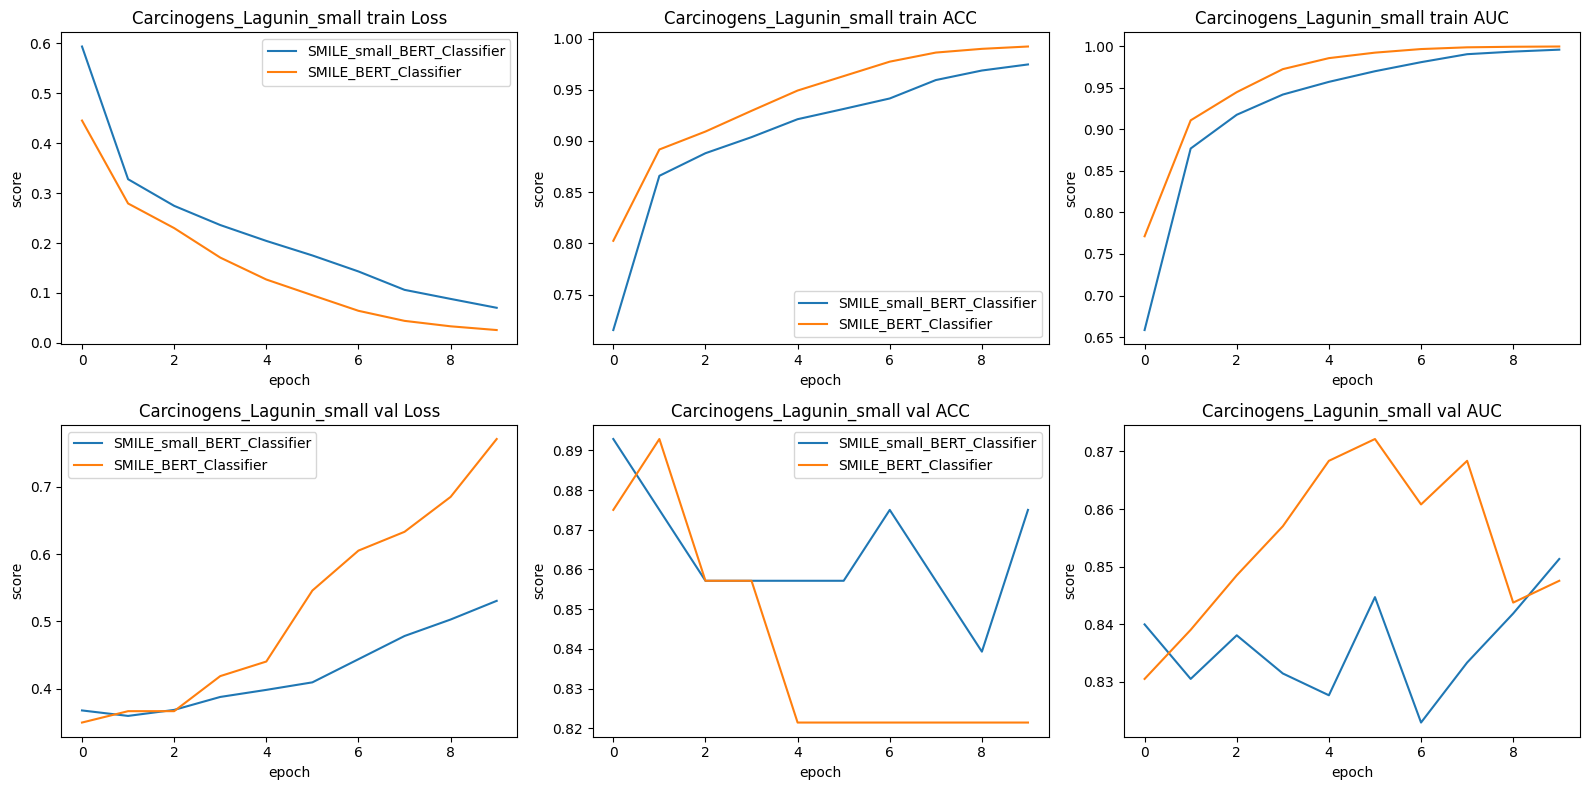

DILI
Epoch 1/10
236/236 [==============================] - 80s 194ms/step - loss: 0.5333 - acc: 0.7441 - auc: 0.8191
Epoch 2/10
236/236 [==============================] - 41s 173ms/step - loss: 0.3735 - acc: 0.8432 - auc: 0.9150
Epoch 3/10
236/236 [==============================] - 41s 173ms/step - loss: 0.2835 - acc: 0.8840 - auc: 0.9507
Epoch 4/10
236/236 [==============================] - 41s 174ms/step - loss: 0.1996 - acc: 0.9209 - auc: 0.9757
Epoch 5/10
236/236 [==============================] - 41s 173ms/step - loss: 0.1402 - acc: 0.9451 - auc: 0.9883
Epoch 6/10
236/236 [==============================] - 41s 172ms/step - loss: 0.0892 - acc: 0.9653 - auc: 0.9955
Epoch 7/10
236/236 [==============================] - 41s 173ms/step - loss: 0.0562 - acc: 0.9807 - auc: 0.9983
Epoch 8/10
236/236 [==============================] - 41s 173ms/step - loss: 0.0409 - acc: 0.9858 - auc: 0.9991
Epoch 9/10
236/236 [==============================] - 41s 173ms/step - loss: 0.0297 - acc: 0.9899 -

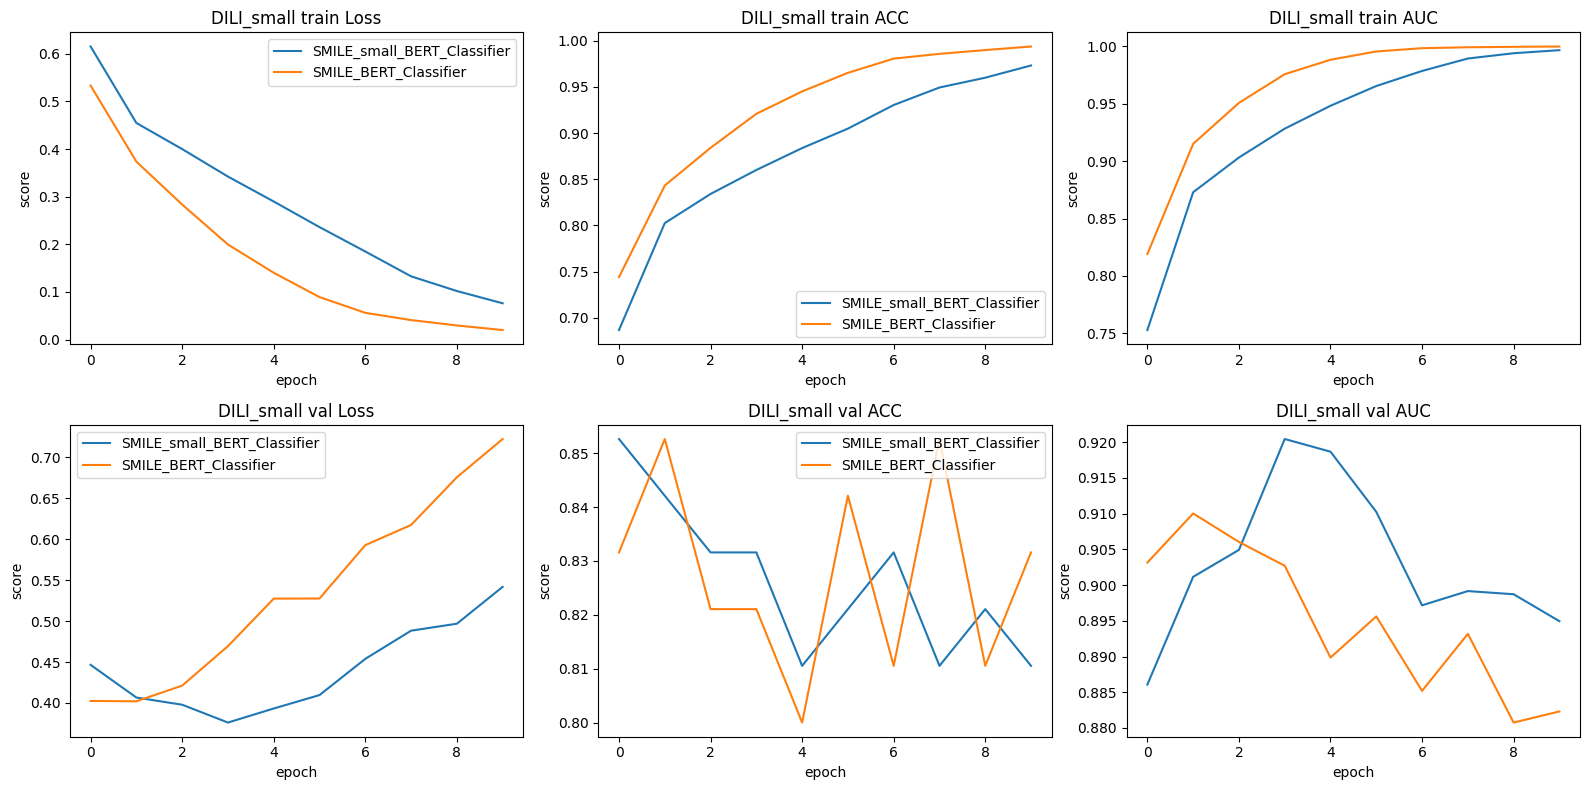

ClinTox
Epoch 1/10
726/726 [==============================] - 152s 165ms/step - loss: 0.2564 - acc: 0.9117 - auc: 0.7506
Epoch 2/10
726/726 [==============================] - 116s 160ms/step - loss: 0.1459 - acc: 0.9456 - auc: 0.9333
Epoch 3/10
726/726 [==============================] - 117s 161ms/step - loss: 0.0970 - acc: 0.9620 - auc: 0.9734
Epoch 4/10
726/726 [==============================] - 116s 160ms/step - loss: 0.0697 - acc: 0.9709 - auc: 0.9874
Epoch 5/10
726/726 [==============================] - 117s 161ms/step - loss: 0.0510 - acc: 0.9795 - auc: 0.9929
Epoch 6/10
726/726 [==============================] - 116s 160ms/step - loss: 0.0419 - acc: 0.9829 - auc: 0.9956
Epoch 7/10
726/726 [==============================] - 117s 161ms/step - loss: 0.0325 - acc: 0.9870 - auc: 0.9971
Epoch 8/10
726/726 [==============================] - 117s 161ms/step - loss: 0.0279 - acc: 0.9888 - auc: 0.9971
Epoch 9/10
726/726 [==============================] - 116s 160ms/step - loss: 0.0256 - a

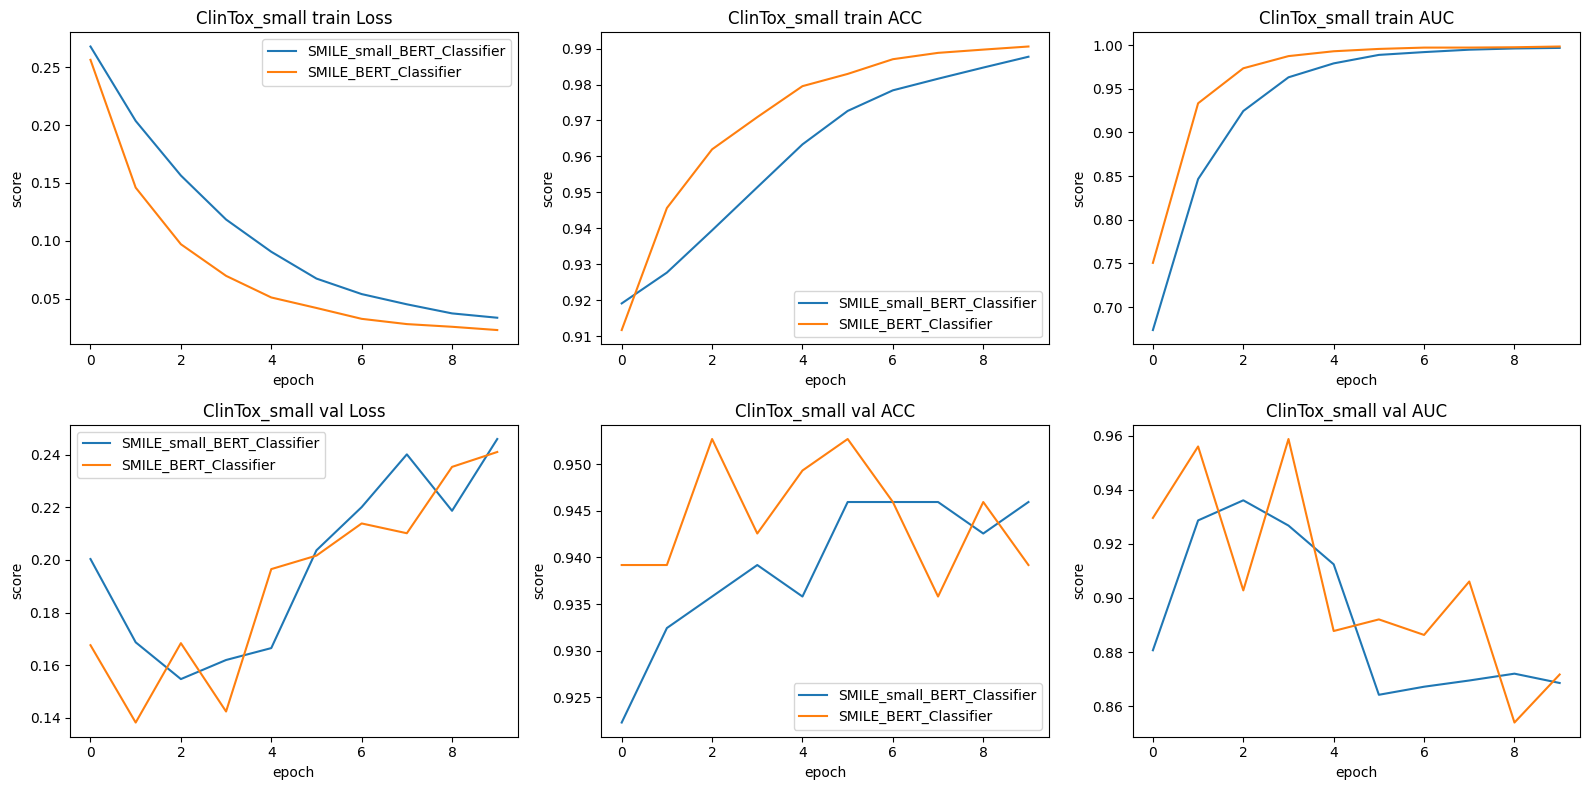

hERG
Unexpected :  [Cu+2]
Unexpected :  [Mn+2]
Unexpected :  [H-]
Unexpected :  [SbH]
Epoch 1/10
328/328 [==============================] - 94s 188ms/step - loss: 0.5017 - acc: 0.7700 - auc: 0.8034
Epoch 2/10
328/328 [==============================] - 57s 173ms/step - loss: 0.3809 - acc: 0.8450 - auc: 0.8928
Epoch 3/10
328/328 [==============================] - 56s 172ms/step - loss: 0.3003 - acc: 0.8788 - auc: 0.9312
Epoch 4/10
328/328 [==============================] - 56s 172ms/step - loss: 0.2292 - acc: 0.9095 - auc: 0.9606
Epoch 5/10
328/328 [==============================] - 57s 174ms/step - loss: 0.1707 - acc: 0.9327 - auc: 0.9787
Epoch 6/10
328/328 [==============================] - 57s 174ms/step - loss: 0.1363 - acc: 0.9463 - auc: 0.9863
Epoch 7/10
328/328 [==============================] - 57s 174ms/step - loss: 0.1049 - acc: 0.9588 - auc: 0.9915
Epoch 8/10
328/328 [==============================] - 56s 172ms/step - loss: 0.0833 - acc: 0.9688 - auc: 0.9947
Epoch 9/10
328/328

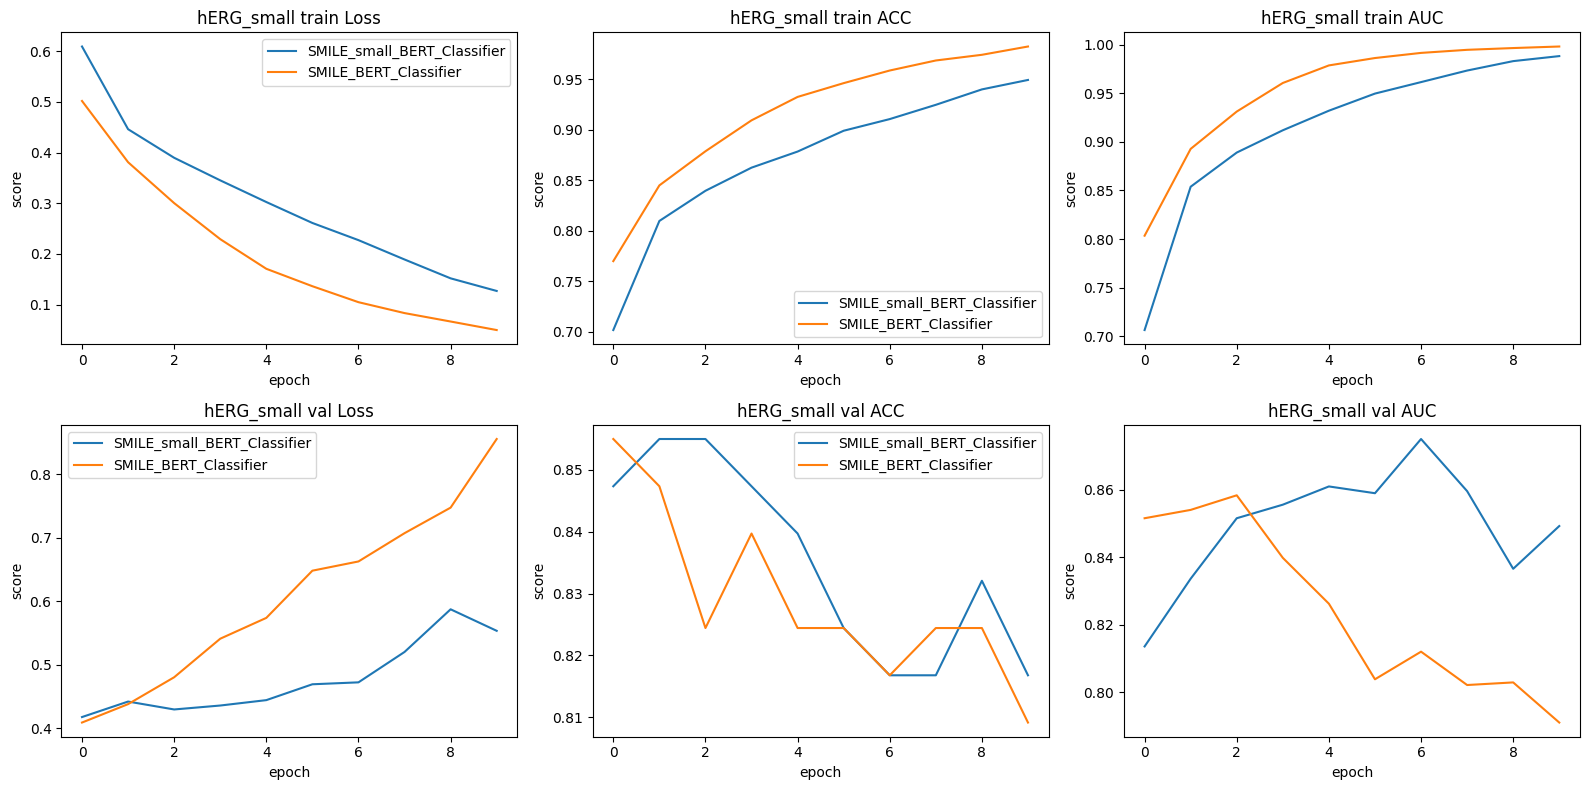

AMES
Epoch 1/10
3499/3499 [==============================] - 645s 174ms/step - loss: 0.5098 - acc: 0.7577 - auc: 0.8322
Epoch 2/10
3499/3499 [==============================] - 606s 173ms/step - loss: 0.3877 - acc: 0.8298 - auc: 0.9054
Epoch 3/10
3499/3499 [==============================] - 605s 173ms/step - loss: 0.3195 - acc: 0.8646 - auc: 0.9363
Epoch 4/10
3499/3499 [==============================] - 605s 173ms/step - loss: 0.2693 - acc: 0.8870 - auc: 0.9548
Epoch 5/10
3499/3499 [==============================] - 604s 173ms/step - loss: 0.2292 - acc: 0.9054 - auc: 0.9672
Epoch 6/10
3499/3499 [==============================] - 603s 172ms/step - loss: 0.1972 - acc: 0.9189 - auc: 0.9756
Epoch 7/10
3499/3499 [==============================] - 603s 172ms/step - loss: 0.1714 - acc: 0.9306 - auc: 0.9814
Epoch 8/10
3499/3499 [==============================] - 605s 173ms/step - loss: 0.1510 - acc: 0.9398 - auc: 0.9855
Epoch 9/10
3499/3499 [==============================] - 608s 174ms/step - l

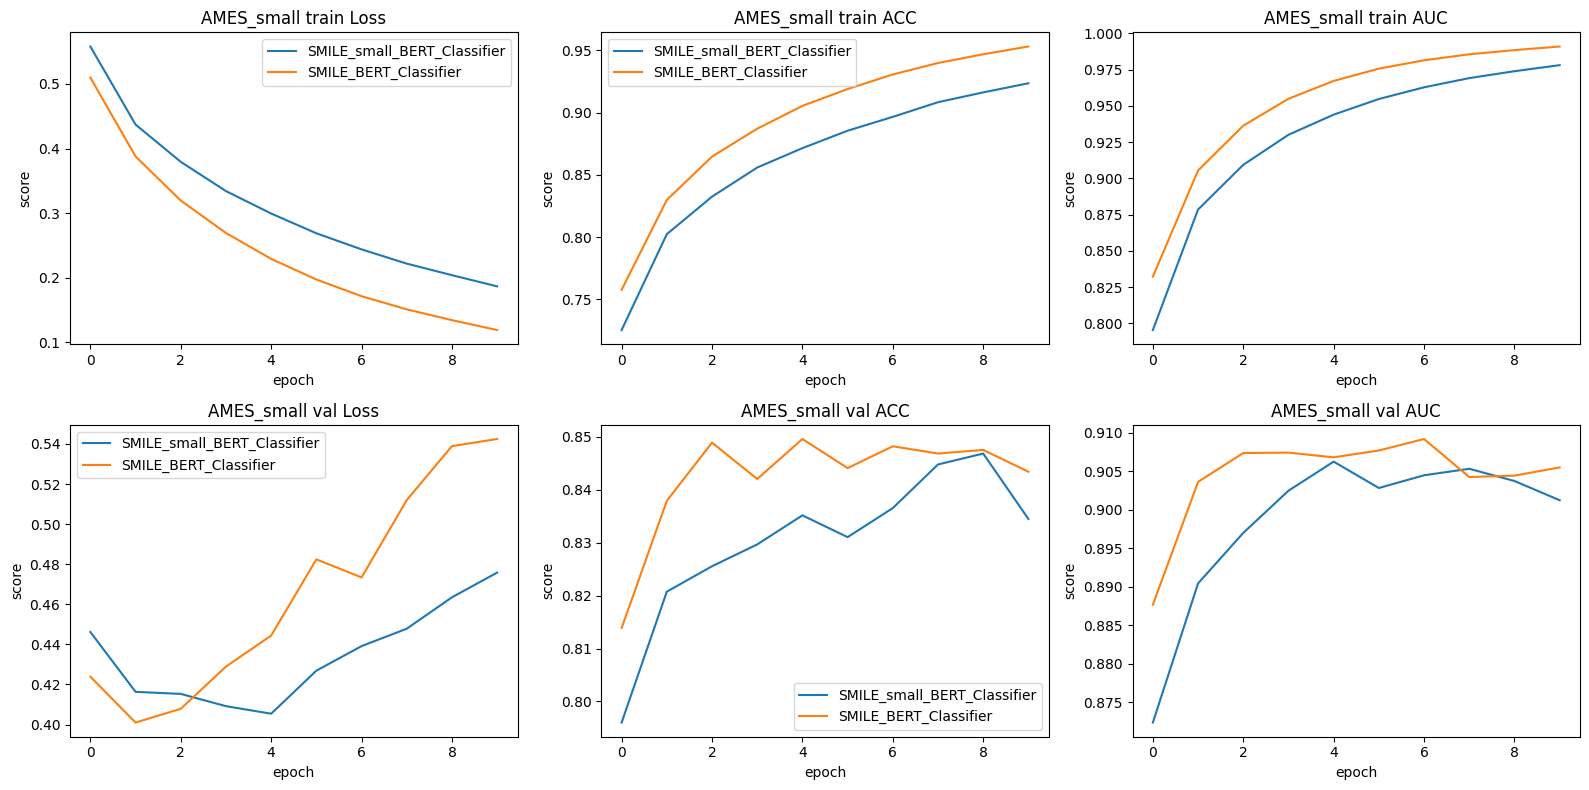

hERG_Karim
Epoch 1/10
6720/6720 [==============================] - 1212s 175ms/step - loss: 0.5394 - acc: 0.7258 - auc: 0.8054
Epoch 2/10
6720/6720 [==============================] - 1168s 174ms/step - loss: 0.4212 - acc: 0.8047 - auc: 0.8877
Epoch 3/10
6720/6720 [==============================] - 1170s 174ms/step - loss: 0.3562 - acc: 0.8412 - auc: 0.9211
Epoch 4/10
6720/6720 [==============================] - 1171s 174ms/step - loss: 0.3045 - acc: 0.8671 - auc: 0.9429
Epoch 5/10
6720/6720 [==============================] - 1168s 174ms/step - loss: 0.2650 - acc: 0.8861 - auc: 0.9569
Epoch 6/10
6720/6720 [==============================] - 1168s 174ms/step - loss: 0.2317 - acc: 0.9020 - auc: 0.9671
Epoch 7/10
6720/6720 [==============================] - 1170s 174ms/step - loss: 0.2030 - acc: 0.9143 - auc: 0.9748
Epoch 8/10
6720/6720 [==============================] - 1173s 174ms/step - loss: 0.1778 - acc: 0.9265 - auc: 0.9806
Epoch 9/10
6720/6720 [==============================] - 1173s

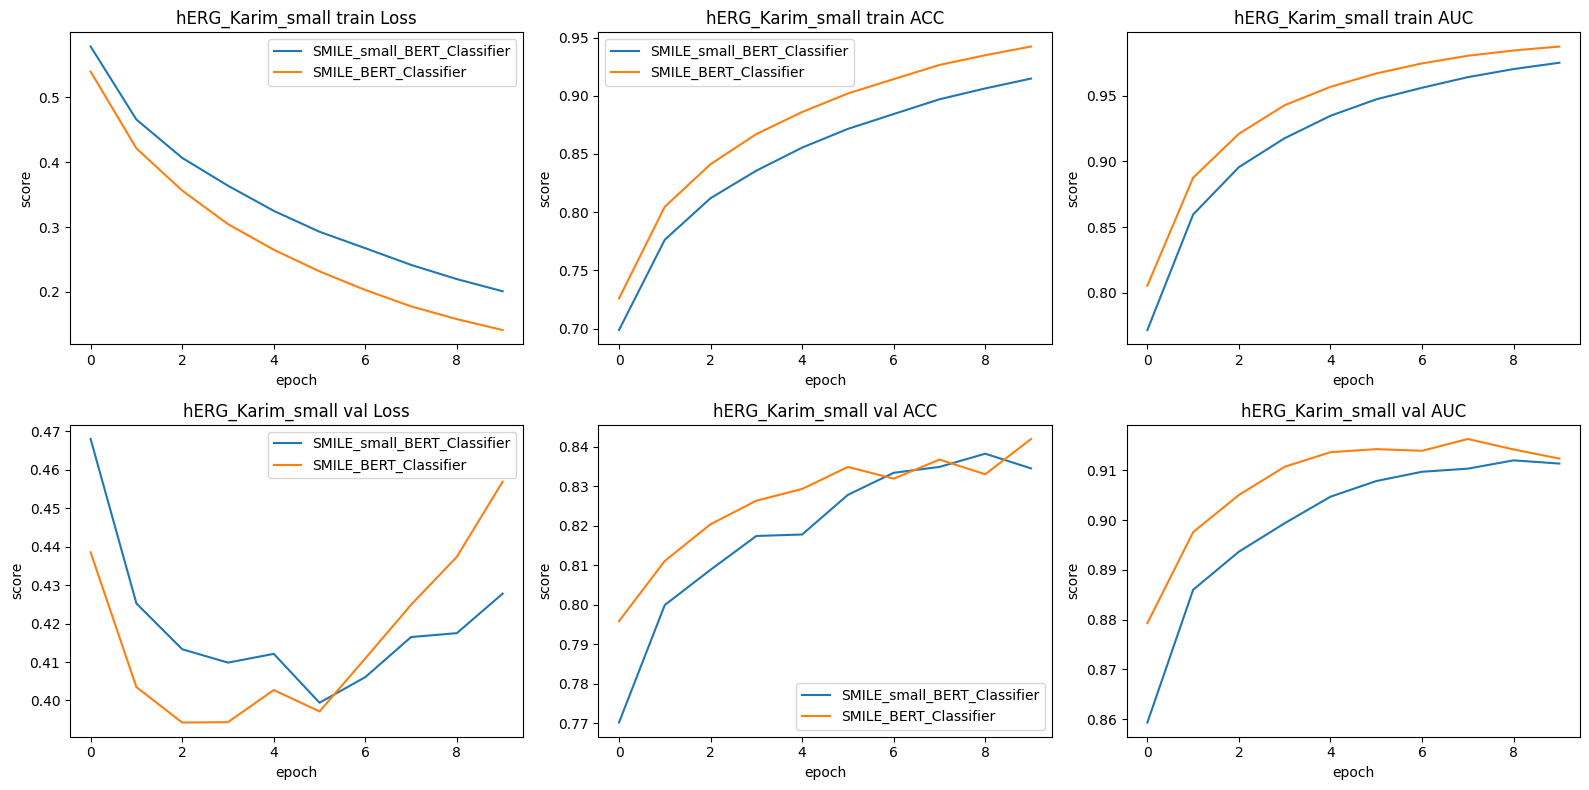

Skin Reaction
Epoch 1/10
193/193 [==============================] - 70s 197ms/step - loss: 0.6496 - acc: 0.6736 - auc: 0.6265
Epoch 2/10
193/193 [==============================] - 33s 173ms/step - loss: 0.5022 - acc: 0.7652 - auc: 0.7951
Epoch 3/10
193/193 [==============================] - 34s 175ms/step - loss: 0.4155 - acc: 0.8118 - auc: 0.8677
Epoch 4/10
193/193 [==============================] - 34s 175ms/step - loss: 0.3369 - acc: 0.8505 - auc: 0.9160
Epoch 5/10
193/193 [==============================] - 34s 174ms/step - loss: 0.2660 - acc: 0.8873 - auc: 0.9480
Epoch 6/10
193/193 [==============================] - 34s 175ms/step - loss: 0.2152 - acc: 0.9117 - auc: 0.9663
Epoch 7/10
193/193 [==============================] - 34s 176ms/step - loss: 0.1661 - acc: 0.9357 - auc: 0.9796
Epoch 8/10
193/193 [==============================] - 33s 173ms/step - loss: 0.1280 - acc: 0.9508 - auc: 0.9877
Epoch 9/10
193/193 [==============================] - 34s 175ms/step - loss: 0.1039 - acc:

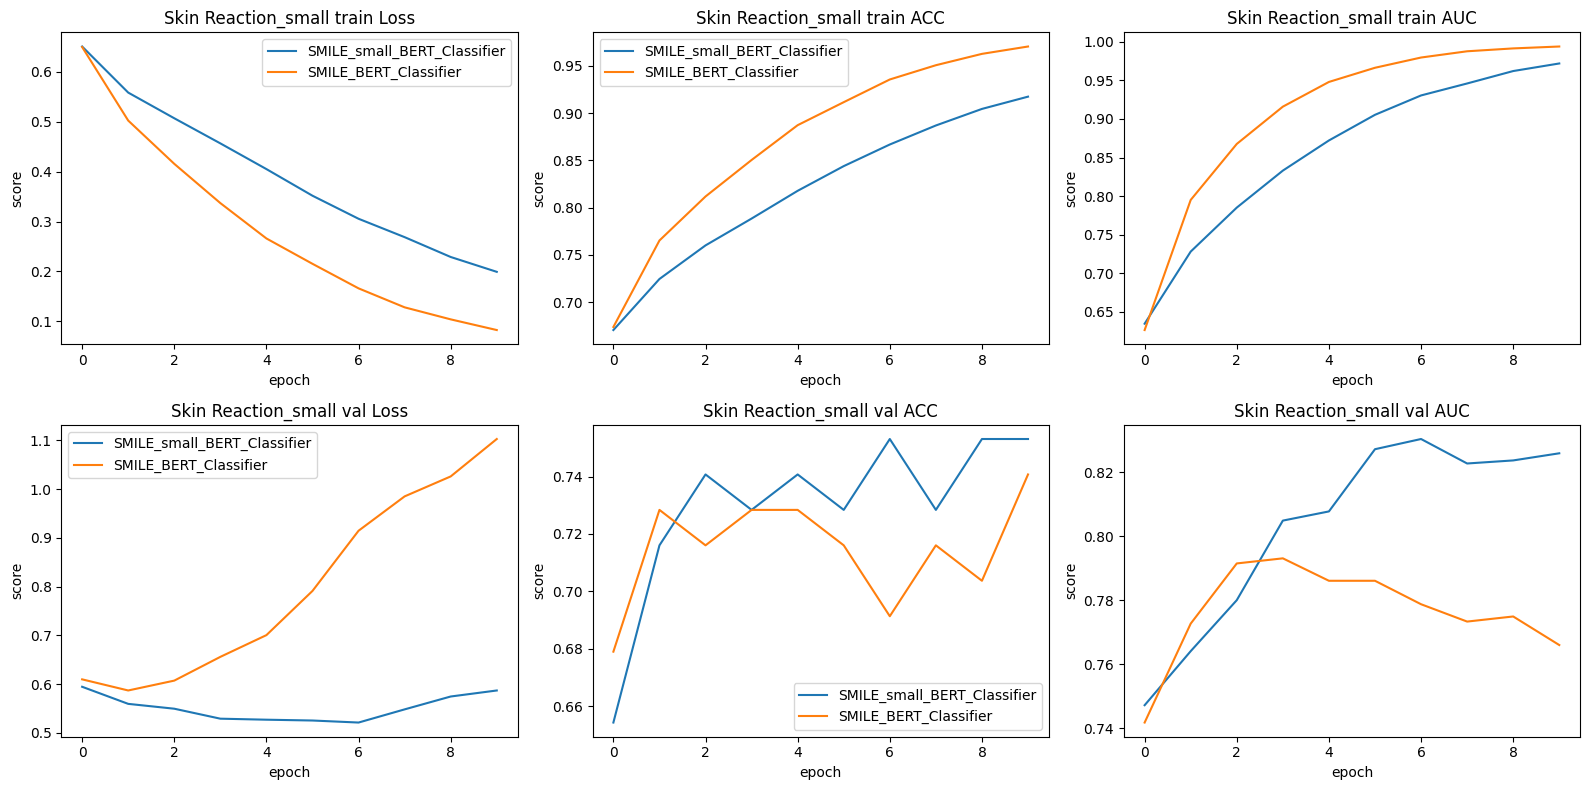

In [7]:

tokens = ['SMILE_small','SMILE']
BERT_names = []

with open('./BERT/SMILE/1M_random_ZINC_word2index.pkl','rb') as file:
    word2idx_SMILE = pickle.load(file)

for token in tokens:
    BERT_names.append(token+"_BERT_Classifier")

for index,tox_name in enumerate(data_sets_SMILE.keys()):
    if tox_name == 'LD50_Zhu':
        continue
    print(tox_name)
    tox_execute_SMILE_small = exe(test_size=0.2,split_seed=42,epoch=10,batch=32,tokens=['SMILE_small'])
    #tox_execute_SMILE = exe(test_size=0.2,split_seed=42,epoch=10,batch=32,tokens=['SMILE'])
    #tox_execute_Bit = exe(test_size=0.2,split_seed=42,epoch=30,batch=32,tokens=['SMILE'])
    #tox_execute_SMILE.forward(data_sets_SMILE[tox_name],word2idx_SMILE)
    tox_execute_SMILE_small.forward(data_sets_SMILE[tox_name],word2idx_SMILE)
    try:
        tox_execute_Bit.bit_forward(data_sets_bit[tox_name])
        models = {tox_execute_SMILE_small.BERTs[0]:BERT_names[0],tox_execute_SMILE.BERTs[0]:BERT_names[1]}
    except:
        print(tox_name,'is not suitable')
        models = {tox_execute_SMILE_small.BERTs[0]:BERT_names[0],tox_execute_SMILE.BERTs[0]:BERT_names[1]}
    execute.plot_history(models,tox_name+'_small',['SMILE_AIS'])

In [15]:
with open('./BERT/SMILE/small_Pre_BERT.pkl','rb') as file:
    temp = pickle.load(file)

In [76]:
from SmilesPE import tokenizer
from rdkit import Chem
from tqdm import tqdm
from tdc.single_pred import Tox
import pickle
import tensorflow as tf 
import numpy as np
from Module import custom_layers

with open('./BERT/SMILE/1M_random_ZINC_word2index.pkl','rb') as file:
    word2idx = pickle.load(file)


## Make Randomized smiles from canonical form
def Chem_generator(smiles,label):
    res_list = []
    len_20 = []
    train_label = []
    index = 0
    for i in tqdm(smiles):
        mol = Chem.MolFromSmiles(i)
        temp = []
        index = 0
        while(len(set(temp))!=20 and index != 100):
            index+=1
            temp.append(Chem.MolToSmiles(mol,doRandom=True))
        temp_res = list(set(temp))
        res_list.append(temp_res)
        len_20.append(len(temp_res))
        train_label.append([label[index]]*len(temp_res))
    return res_list,len_20,train_label

def flatten(input_list):
    res = []
    for seq in input_list:
        for single in seq:
            res.append(single)
    return np.array(res)
    
    

## Preprocess for SMILE
def Preprocess(smiles,label):
    smiles,len_20,train_label = Chem_generator(smiles,label)
    image = []
    for smile in smiles:
        part_image = []
        for single_smile in smile:
            temp = []
            single_smile = tokenizer.atomwise_tokenizer(single_smile)
            for token in single_smile:
                try:
                    temp.append(word2idx[token])
                except:
                    print(token,' is not in the word2idx')
                    word2idx[token] = len(word2idx)+1
            part_image.append(temp)
        image.append(part_image)
    train_image = []
    for single_image in image:
        temp = tf.keras.preprocessing.sequence.pad_sequences(single_image,200,padding='post')
        temp = temp.astype(np.int32)
        train_image.append(temp)
        
    
    return train_image, train_label, len_20

def read_folder(folder_path):
    file_list = os.listdir(folder_path)
    csv_files = [file for file in file_list if file.endswith('.csv')]
    dataframes = []
    for csv_file in csv_files:
        file_path = os.path.join(folder_path, csv_file)
        df = pd.read_csv(file_path)
        dataframes.append(df)
    return dataframes


def Task_mask(num_task):
    result = np.zeros([200,200])
    for i in range(num_task):
        for j in range(200):
            if j == i:
                continue
            else:
                result[j][i] = 1
    return result

import pandas as pd
import random
def split(df,ratio = [0.8,0.1,0.1]):

    # 행 수를 가져옵니다.
    total_rows = len(df)

    # 8:1:1 비율로 행을 나눕니다.
    train_ratio = ratio[0]
    val_ratio = ratio[1]

    # 행의 인덱스를 랜덤하게 섞습니다.
    indices = list(df.index)
    random.shuffle(indices)

    # 각 데이터 세트의 크기를 계산합니다.
    train_size = int(total_rows * train_ratio)
    val_size = int(total_rows * val_ratio)

    # 랜덤하게 선택된 인덱스로 데이터를 분할합니다.
    train_indices = indices[:train_size]
    val_indices = indices[train_size:(train_size + val_size)]
    test_indices = indices[(train_size + val_size):]

    # 데이터를 나눠서 추출합니다.
    result = {}
    
    result['train'] = df.loc[train_indices]
    result['val'] = df.loc[val_indices]
    result['test'] = df.loc[test_indices]
    return result
    
def tensor_BERT_small(number_of_task,task_index = 0):
    with open('./BERT/SMILE/small_Pre_BERT.pkl','rb') as file:
        paras = pickle.load(file)
    if number_of_task == 0:
        mask = Task_mask(number_of_task+1)
    else:
        mask = Task_mask(number_of_task)
    bert_layer = custom_layers.BERT_tensor_small(256,8,1024,strat_index=number_of_task)
    inputs = tf.keras.layers.Input(200,dtype=tf.int32)
    hidden = bert_layer(inputs,att_mask = mask)
    hidden = hidden[:,task_index]
    hidden = tf.keras.layers.Dropout(0.3)(hidden)
    output = tf.keras.layers.Dense(1,activation = 'sigmoid')(hidden)
    result = tf.keras.Model(inputs = [inputs],outputs = [output])
    result.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5),loss = 'binary_crossentropy',metrics=['acc',tf.keras.metrics.AUC(name='auc')])
    result.layers[1].set_weights(paras)
    return result
    
    
def tensor_BERT(number_of_task,task_index = 0):
    with open('./BERT/SMILE/Pre_BERT.pkl','rb') as file:
        paras = pickle.load(file)
    if number_of_task == 0:
        mask = Task_mask(number_of_task+1)
    else:
        mask = Task_mask(number_of_task)
    bert_layer = custom_layers.BERT_tensor(256,6,1024,strat_index=number_of_task)
    inputs = tf.keras.layers.Input(200,dtype=tf.int32)
    hidden = bert_layer(inputs,att_mask = mask)
    hidden = hidden[:,task_index]
    hidden = tf.keras.layers.Dropout(0.3)(hidden)
    output = tf.keras.layers.Dense(1,activation = 'sigmoid')(hidden)
    result = tf.keras.Model(inputs = [inputs],outputs = [output])
    result.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5),loss = 'binary_crossentropy',metrics=['acc',tf.keras.metrics.AUC(name='auc')])
    result.layers[1].set_weights(paras)
    return result


    

def main():
    data = pd.read_csv('./RAW_data/AMES.csv')
    data_set = split(data)
    train_set = Preprocess(data_set['train']['Drug'].to_numpy(),data_set['train']['Y'].to_numpy())
    val_set = Preprocess(data_set['val']['Drug'].to_numpy(),data_set['val']['Y'].to_numpy())
    test_set = Preprocess(data_set['test']['Drug'].to_numpy(),data_set['test']['Y'].to_numpy())
    train_shuffle = list(zip(flatten(train_set[0]),flatten(train_set[1])))
    random.shuffle(train_shuffle)
    train_shuffle = list(zip(*train_shuffle))
    train_shuffle[0] = np.array(train_shuffle[0])
    train_shuffle[1] = np.array(train_shuffle[1])
    tensor_BERT_small(2).summary()
    tensor_BERT_small(2)(flatten(train_set[0][:10]))
    
main()
    

  3%|▎         | 152/5822 [00:00<00:08, 661.42it/s]

100%|██████████| 729/729 [00:00<00:00, 818.64it/s]


Model: "model_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_27 (InputLayer)       [(None, 200)]             0         
                                                                 
 bert_tensor_small_25 (BERT_  (None, 200, 256)         4519232   
 tensor_small)                                                   
                                                                 
 tf.__operators__.getitem_25  (None, 256)              0         
  (SlicingOpLambda)                                              
                                                                 
 dropout_457 (Dropout)       (None, 256)               0         
                                                                 
 dense_1764 (Dense)          (None, 1)                 257       
                                                                 
Total params: 4,519,489
Trainable params: 4,519,489
Non-tr

2024-01-03 13:57:02.192662: W tensorflow/core/framework/op_kernel.cc:1818] INTERNAL: 'cuLaunchKernel(function, gridX, gridY, gridZ, blockX, blockY, blockZ, 0, reinterpret_cast<CUstream>(stream), params, nullptr)' failed with 'CUDA_ERROR_INVALID_VALUE'


InternalError: Exception encountered when calling layer 'bert_tensor_small_26' (type BERT_tensor_small).

{{function_node __wrapped__FloorMod_device_/job:localhost/replica:0/task:0/device:GPU:0}} 'cuLaunchKernel(function, gridX, gridY, gridZ, blockX, blockY, blockZ, 0, reinterpret_cast<CUstream>(stream), params, nullptr)' failed with 'CUDA_ERROR_INVALID_VALUE' [Op:FloorMod]

Call arguments received by layer 'bert_tensor_small_26' (type BERT_tensor_small):
  • inputs=tf.Tensor(shape=(200, 200), dtype=int32)
  • mask_index=None
  • pretrain=False
  • att_mask=array([[0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 1., 0., ..., 0., 0., 0.],
       ...,
       [1., 1., 0., ..., 0., 0., 0.],
       [1., 1., 0., ..., 0., 0., 0.],
       [1., 1., 0., ..., 0., 0., 0.]])

In [77]:
data = pd.read_csv('./RAW_data/AMES.csv')
data_set = split(data)
train_set = Preprocess(data_set['train']['Drug'].to_numpy(),data_set['train']['Y'].to_numpy())
val_set = Preprocess(data_set['val']['Drug'].to_numpy(),data_set['val']['Y'].to_numpy())
test_set = Preprocess(data_set['test']['Drug'].to_numpy(),data_set['test']['Y'].to_numpy())



100%|██████████| 729/729 [00:00<00:00, 1016.22it/s]


Model: "model_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_29 (InputLayer)       [(None, 200)]             0         
                                                                 
 bert_tensor_small_27 (BERT_  (None, 200, 256)         4519232   
 tensor_small)                                                   
                                                                 
 tf.__operators__.getitem_27  (None, 256)              0         
  (SlicingOpLambda)                                              
                                                                 
 dropout_491 (Dropout)       (None, 256)               0         
                                                                 
 dense_1896 (Dense)          (None, 1)                 257       
                                                                 
Total params: 4,519,489
Trainable params: 4,519,489
Non-tr

2024-01-03 14:00:16.599641: W tensorflow/tsl/framework/bfc_allocator.cc:479] Allocator (GPU_0_bfc) ran out of memory trying to allocate 30.52MiB (rounded to 32000000)requested by op Transpose
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2024-01-03 14:00:16.599790: I tensorflow/tsl/framework/bfc_allocator.cc:1034] BFCAllocator dump for GPU_0_bfc
2024-01-03 14:00:16.599817: I tensorflow/tsl/framework/bfc_allocator.cc:1041] Bin (256): 	Total Chunks: 401, Chunks in use: 399. 100.2KiB allocated for chunks. 99.8KiB in use in bin. 69.9KiB client-requested in use in bin.
2024-01-03 14:00:16.599836: I tensorflow/tsl/framework/bfc_allocator.cc:1041] Bin (512): 	Total Chunks: 90, Chunks in use: 87. 58.5KiB allocated for chunks. 56.5KiB in use in bin. 53.2KiB client-requested in use in bin.
2024-01-03 14:00:16.599853: I tensorflow/tsl/fram

ResourceExhaustedError: Exception encountered when calling layer 'bert_tensor_small_28' (type BERT_tensor_small).

{{function_node __wrapped__Transpose_device_/job:localhost/replica:0/task:0/device:GPU:0}} OOM when allocating tensor with shape[200,200,200] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Transpose]

Call arguments received by layer 'bert_tensor_small_28' (type BERT_tensor_small):
  • inputs=tf.Tensor(shape=(200, 200), dtype=int32)
  • mask_index=None
  • pretrain=False
  • att_mask=array([[0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 1., 0., ..., 0., 0., 0.],
       ...,
       [1., 1., 0., ..., 0., 0., 0.],
       [1., 1., 0., ..., 0., 0., 0.],
       [1., 1., 0., ..., 0., 0., 0.]])

In [95]:
temp = list(zip(flatten(train_set[0]),flatten(train_set[1])))
random.shuffle(temp)

[[20  8 10 ...  0  0  0]
 [11 10 48 ...  0  0  0]
 [ 8 10 12 ...  0  0  0]
 ...
 [15 12  8 ...  0  0  0]
 [ 8 12 21 ...  0  0  0]
 [20  8 21 ...  0  0  0]]
[1 1 1 ... 0 0 0]


In [98]:
temp = list(zip(*temp))

In [99]:
temp[0]

(array([13, 12, 13, 12, 11, 10, 11, 11, 11,  9, 11, 10, 18,  8, 18, 19, 20,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0], dtype=int32),
 array([11, 10, 14, 11, 12, 13, 12,  8, 18,  8, 18, 16, 11,  9, 11, 36, 10,
         9, 1

In [57]:
result = split(df.get_data())

In [58]:
len(result['test'])

48

In [47]:
tox_names = ['herg']

df = Tox('DILI')

Found local copy...
Loading...
Done!


In [48]:
df.get_split

In [ ]:
import pandas as pd

# CSV 파일을 읽어옵니다.
csv_file_path = './Final_data/CLS/BBBP_MoleculeNet.csv'
df = pd.read_csv(csv_file_path)

# 열 이름을 변경합니다.
# 예를 들어, '기존열'을 '새로운열이름'으로 변경하는 경우:
df.rename(columns={'기존열': '새로운열이름'}, inplace=True)

# 수정된 데이터프레임을 CSV 파일로 저장합니다.
df.to_csv('수정된파일경로.csv', index=False) 

In [59]:
import pandas as pd

# CSV 파일을 읽어옵니다.
tox_names = ['hERG','hERG_Karim','AMES','DILI','Skin Reaction','Carcinogens_Lagunin', 'ClinTox']
for tox_name in tox_names:
    df = Tox(name=tox_name).get_data()
    df.to_csv(f'{tox_name}.csv', index=False) 

Found local copy...
Loading...
Done!
Found local copy...
Loading...
Done!
Found local copy...
Loading...
Done!
Found local copy...
Loading...
Done!
Found local copy...
Loading...
Done!
Found local copy...
Loading...
Done!
Found local copy...
Loading...
Done!


In [18]:
import os
import pandas as pd

# 읽을 CSV 파일들이 있는 폴더 경로 설정
folder_path = '/경로/특정/폴더'

# 폴더 내 모든 파일 목록 가져오기
file_list = os.listdir(folder_path)

# CSV 파일만 선택하기
csv_files = [file for file in file_list if file.endswith('.csv')]
csv_file_path = './Final_data/CLS/BBBP_MoleculeNet.csv'
df = pd.read_csv(csv_file_path)
df.rename(columns={'smiles': 'Drug'}, inplace=True)
df.rename(columns={'p_np': 'Y'}, inplace=True)

In [34]:
import os
import pandas as pd

# 읽을 CSV 파일들이 있는 폴더 경로 설정
folder_path = './Final_data/CLS/'

# 폴더 내 모든 파일 목록 가져오기
file_list = os.listdir(folder_path)

# CSV 파일만 선택하기
csv_files = [file for file in file_list if file.endswith('.csv')]
dataframes = []
for csv_file in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    df = pd.read_csv(file_path)
    df.rename(columns={'SMILES': 'Drug'}, inplace=True)
    df.rename(columns={'Smiles': 'Drug'}, inplace=True)
    df.rename(columns={'smiles': 'Drug'}, inplace=True)
    df.rename(columns={'Property': 'Y'}, inplace=True)
    df.rename(columns={'p_np': 'Y'}, inplace=True)
    move_file_path = os.path.join('./RAW_data/', csv_file)
    df.to_csv(move_file_path, index=False)
    

In [27]:
csv_files

['BBBP_vNN-ADMET.csv',
 'BBBP_MoleculeNet_clean.csv',
 'DILI_vNN-ADMET.csv',
 'CYP2C19_Inhibitor_vNN-ADMET.csv',
 'CYP3A4_Inhibitor_vNN-ADMET.csv',
 'CYP2D6_Inhibitor_vNN-ADMET.csv',
 'Hepatotoxicity-Cytotoxicity-HepG2_vNN-ADMET.csv',
 'CYP1A2_Inhibitor_vNN-ADMET.csv',
 'BBBP_MoleculeNet.csv',
 'CYP2C9_Inhibitor_vNN-ADMET.csv',
 'HLM_metab_vNN-ADMET.csv']

In [22]:
temp  = pd.read_csv('./RAW_data/BBBP_MoleculeNet.csv')

In [20]:
df.to_csv('./RAW_data/BBBP_MoleculeNet.csv', index=False)

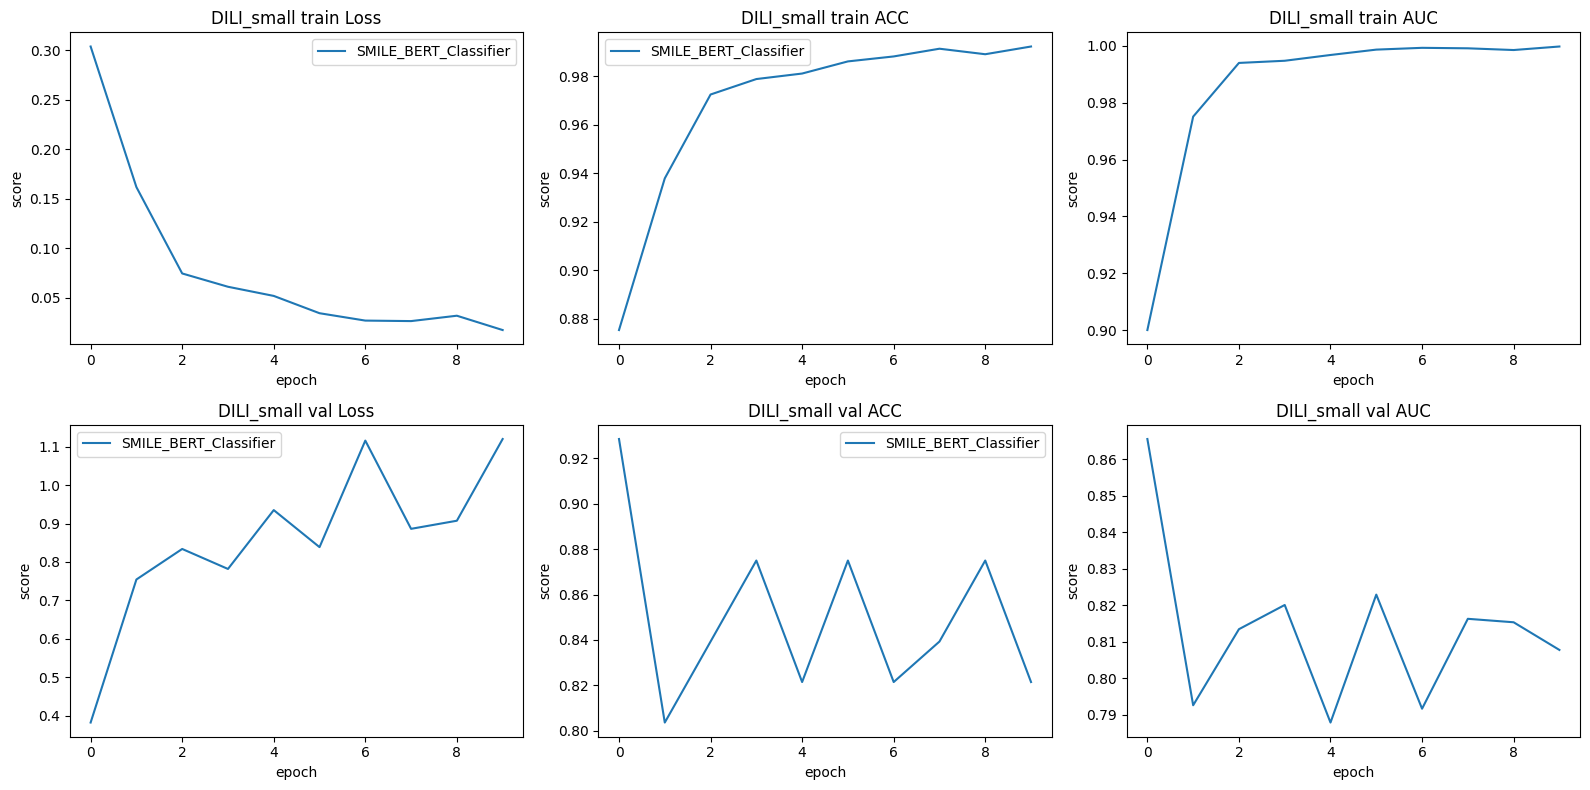

In [17]:
execute.plot_history(models,tox_name+'_small',['SMILE_AIS'])

In [12]:
try:
    tox_execute_Bit.bit_forward(data_sets_bit['CYP2C9_Inhibitor_vNN-ADMET'])
    models = {tox_execute_AIS.Bit:'Bit_Classifier',tox_execute_AIS.BERTs[0]:BERT_names[0],tox_execute_SMILE.BERTs[0]:BERT_names[1]}
except:
    print(tox_name,'is not suitable')
    models = {tox_execute_AIS.BERTs[0]:BERT_names[0]}

Epoch 1/30
202/202 [==============================] - 12s 51ms/step - loss: 0.5861 - acc: 0.8750 - auc: 0.6610 - val_loss: 0.4829 - val_acc: 0.8854 - val_auc: 0.8354
Epoch 2/30
202/202 [==============================] - 2s 10ms/step - loss: 0.3867 - acc: 0.8973 - auc: 0.8463 - val_loss: 0.4350 - val_acc: 0.8947 - val_auc: 0.8417
Epoch 3/30
202/202 [==============================] - 2s 12ms/step - loss: 0.3412 - acc: 0.9064 - auc: 0.8823 - val_loss: 0.4060 - val_acc: 0.8934 - val_auc: 0.8519
Epoch 4/30
202/202 [==============================] - 2s 12ms/step - loss: 0.3237 - acc: 0.9117 - auc: 0.8953 - val_loss: 0.4037 - val_acc: 0.8934 - val_auc: 0.8577
Epoch 5/30
202/202 [==============================] - 2s 12ms/step - loss: 0.2953 - acc: 0.9227 - auc: 0.9226 - val_loss: 0.4085 - val_acc: 0.9002 - val_auc: 0.8590
Epoch 6/30
202/202 [==============================] - 2s 12ms/step - loss: 0.2805 - acc: 0.9291 - auc: 0.9349 - val_loss: 0.4107 - val_acc: 0.8848 - val_auc: 0.8504
Epoch 7/3

In [ ]:
tokens = ['AIS']
BERT_names = []

for token in tokens:
    BERT_names.append(token+"_BERT_Classifier")

for index,tox_name in enumerate(data_sets):
    print(tox_names[index])
    tox_execute = exe(test_size=0.2,split_seed=42,epoch=10,batch=32)
    tox_execute.forward(tox_name,word2idx)
    try:
        tox_execute.bit_forward(data_sets_bit[tox_names[index][:-4]])
        models = {tox_execute.Bit:'Bit_Classifier',tox_execute.BERTs[0]:BERT_names[0]}
    except:
        print(tox_names[index][:-4],'is not suitable')
        models = {tox_execute.BERTs[0]:BERT_names[0]}
        continue
    execute.plot_history(models,tox_names[index][:-4],['SMILE_AIS'])

In [ ]:
tox_execute = exe(test_size=0.2,split_seed=42,epoch=10,batch=32)
tox_execute.bit_forward(data_sets_bit['DILI_vNN-ADMET'])

Epoch 1/10


2023-12-29 23:12:00.650395: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-12-29 23:12:00.657519: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x555ef64bcf80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-29 23:12:00.657578: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA A100 80GB PCIe, Compute Capability 8.0
2023-12-29 23:12:00.672760: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-12-29 23:12:00.819813: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


36/36 [==============================] - 5s 64ms/step - loss: 0.6796 - acc: 0.5539 - auc: 0.5775 - val_loss: 0.6514 - val_acc: 0.6399 - val_auc: 0.6536
Epoch 2/10
36/36 [==============================] - 0s 13ms/step - loss: 0.6017 - acc: 0.6626 - auc: 0.7294 - val_loss: 0.6409 - val_acc: 0.6503 - val_auc: 0.6585
Epoch 3/10
36/36 [==============================] - 1s 14ms/step - loss: 0.4975 - acc: 0.7660 - auc: 0.8438 - val_loss: 0.6895 - val_acc: 0.6503 - val_auc: 0.6701
Epoch 4/10
36/36 [==============================] - 0s 14ms/step - loss: 0.3936 - acc: 0.8309 - auc: 0.9132 - val_loss: 0.7437 - val_acc: 0.6503 - val_auc: 0.6608
Epoch 5/10
36/36 [==============================] - 0s 13ms/step - loss: 0.3034 - acc: 0.8861 - auc: 0.9460 - val_loss: 0.8932 - val_acc: 0.6364 - val_auc: 0.6681
Epoch 6/10
36/36 [==============================] - 1s 14ms/step - loss: 0.2347 - acc: 0.9141 - auc: 0.9685 - val_loss: 1.0060 - val_acc: 0.6434 - val_auc: 0.6561
Epoch 7/10
36/36 [===============

In [36]:
tox_names = ['hERG','AMES',"Carcinogens_Lagunin",'ClinTox','hERG_Karim']
BERT_names = []

for token in tokens:
    BERT_names.append(token+"_BERT_Classifier")

for tox_name in tox_names:
    tox_execute = exe(tox_name,0.2,552,epoch=20,batch=32,tokens=tokens)
    tox_execute.forward()
    globals()['tox_execute_'+tox_name] = tox_execute
    
    models = {tox_execute.Bit:'Bit_Classifier',tox_execute.BERTs[0]:BERT_names[0],tox_execute.BERTs[1]:BERT_names[1]}
    execute.plot_history(models,tox_name,['SMILE_AIS'])

Epoch 1/20
 93/328 [=======>......................] - ETA: 44s - loss: 0.5295 - acc: 0.7476 - auc: 0.7370

KeyboardInterrupt: 

In [325]:
from Module import custom_layers
import tensorflow as tf

BERT_tensor = custom_layers.BERT_tensor

bert_layer = BERT_tensor(256,6,1024,strat_index=10)

In [326]:
from tensorflow.keras import Model
inputs = tf.keras.layers.Input(shape = (200,),dtype=tf.int32)
outputs = bert_layer(inputs,None)

model = Model(inputs = [inputs], outputs = [outputs])

In [327]:
model.load_weights('./BERT/atomInSmile/small_tensor_Pre_BERT')
paras = model.get_weights()
bert_layer.set_weights(paras)

In [328]:
import numpy as np
def Task_mask(num_task):
    result = np.zeros([200,200])
    for i in range(num_task):
        for j in range(200):
            if j == i:
                continue
            else:
                result[j][i] = 1
    return result

In [329]:
mask = Task_mask(10)

In [330]:
from tensorflow.keras import Model
from tensorflow.keras.metrics import AUC
Models = []

Input = tf.keras.layers.Input(200,)
hidden = bert_layer(Input,att_mask = mask)
output = hidden[:,0]
output = tf.keras.layers.Dense(256,activation = 'gelu')(output)
output = tf.keras.layers.Dense(1)(output)
globals()[f'Task{0}_model'] = Model(inputs = [Input],outputs = [output])
globals()[f'Task{0}_model'].compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5))
Models.append(globals()[f'Task{0}_model'])

for i in range(9):
    i = i+1
    Input = tf.keras.layers.Input(200,)
    hidden = bert_layer(Input,att_mask = mask)
    output = hidden[:,i]
    output = tf.keras.layers.Dense(256,activation = 'gelu')(output)
    output = tf.keras.layers.Dense(1,activation = 'sigmoid')(output)
    globals()[f'Task{i}_model'] = Model(inputs = [Input],outputs = [output])
    globals()[f'Task{i}_model'].compile(optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5),loss = 'binary_crossentropy',metrics=['acc',AUC(name='auc')])
    Models.append(globals()[f'Task{i}_model'])
    

In [259]:
import os
import tensorflow as tf 
from tensorflow.python.client import device_lib
import pickle
import numpy as np
from tensorflow.keras.metrics import AUC
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.layers import Input
from tensorflow.keras import layers
from tensorflow.keras import Model
import matplotlib.pyplot as plt
from difflib import SequenceMatcher
from sklearn.model_selection import train_test_split
from tdc.single_pred import Tox
from Module import RDK


class TokenAndPositionEmbedding(tf.keras.layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embed_dim,mask_zero=True)
        self.pos_emb = tf.keras.layers.Embedding(input_dim=maxlen, output_dim=embed_dim,mask_zero = True)

    def call(self, x):
        positions = np.array([0]+[0]+[i+2 for i in range(198)])
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions    
    
    
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        l2_reg = tf.keras.regularizers.l2(0.01)
        
        self.att = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim,kernel_regularizer=l2_reg)
        self.ffn = tf.keras.Sequential(
            [tf.keras.layers.Dense(ff_dim, activation="relu"), tf.keras.layers.Dense(embed_dim),]
        )
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, inputs):
        attn_output = self.att(inputs, inputs,attention_mask=tf.cast(np.array([[1]+[0]+[1]*198] + [[0]+[1]*199] + [[0]*2+[1]*198]*198),bool))
        attn_output = self.dropout1(attn_output)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        return self.layernorm2(out1 + ffn_output)
    
    
    
    
class BERT(tf.keras.layers.Layer):
    def __init__(self,emb_dim,num_heads,ff_dim):
        super(BERT, self).__init__()
        self.encoder = tf.keras.Sequential([TransformerBlock(emb_dim,num_heads,ff_dim) for i in range(8)])
        
        self.embedding = TokenAndPositionEmbedding(200,3500,256)
        self.dense = tf.keras.layers.Dense(250,activation = 'gelu')
        self.classify = tf.keras.layers.Dense(71,activation = 'softmax')
    def call(self, inputs, mask_index=None,pretrain = False):
        if pretrain:
            mask_index = tf.one_hot(mask_index,200)
            boolean_mask = tf.cast(tf.reduce_sum(mask_index,axis=1),bool)
            inputs = tf.cast(inputs,dtype=tf.int32)
        
        inputs = tf.reshape(inputs,[-1,200])
        hidden = self.embedding(inputs)
        
        
        hidden = self.encoder(hidden)
    
        if pretrain:
            output = tf.reshape(hidden,[-1,200,256])
            output = self.dense(output)
            output = layers.Dropout(0.1)(output)
            output = self.classify(output)
            output = tf.boolean_mask(output,boolean_mask)
            return output
        else:
            return hidden


def predict(model,results,len_list):
    index = 0
    res = model.predict(results,verbose=0)
    x_val = []
    for i in len_list:
        temp = res[index:index+i]
        x_val.append(np.average(temp,axis=0))
        index = index+i
    return np.array(x_val)

def similar(a, b):    return SequenceMatcher(None, a, b).ratio()
def most_similar(query,word2idx):

    max = 0
    tokken = ''
    query = query.split(';')
    for i in word2idx.keys():
        key = i.split(';')
        temp2 = 0
        temp3 = 0
        temp1 = similar(query[0],key[0])*10
        try:
            temp2 = similar(query[1],key[1])*2
            temp3 = similar(query[2],key[2])*1
        except:
            pass
        temp = temp1+temp2+temp3
        if temp>max:
            max = temp
            tokken = i
    return tokken

from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self, x_val,y_true,len_20):
        super().__init__()
        self.x_val = x_val
        index = 0
        res = []
        for i in len_20:
            res.append(np.average(y_true[index:index+i]))
            index = index+i
        self.len20 = len_20
        self.counts = []
        self.max = 0
        self.y_true = np.array(res)
        self.history = {}
        self.epoch = 0
    def on_epoch_end(self, epoch, logs=None):
        # 에포크가 끝날 때마다 validation 데이터로 모델 평가
        result = predict(self.model,self.x_val,self.len20)
        acc = Accuracy()(self.y_true,np.round(result))
        auc_res = (AUC()(self.y_true,result)).numpy()
        loss = tf.keras.metrics.BinaryCrossentropy()(self.y_true,result)
        auc_res = auc_res
        print(f"     val_acc : {acc},    val_auc : {auc_res} val_loss : {loss}")
        if 'val_acc' not in self.history:
            self.history['val_acc'] = [acc]
        else:
            self.history['val_acc'] += [acc]
        if 'val_auc' not in self.history:
            self.history['val_auc'] = [auc_res]
        else:
            self.history['val_auc'] += [auc_res]
        
        if 'val_loss' not in self.history:
            self.history['val_loss'] = [loss]
        else:
            self.history['val_loss'] += [loss]
        
        self.max = np.max(self.history['val_auc'])
            
        if self.history['val_auc'][-1]<self.max:
            self.counts.append(1)
        else:
            self.counts = []

        self.epoch += 1
        """
        if self.epoch>10 and len(self.counts)>2:
            self.model.stop_training = True"""



inputs = Input(shape = (200,),dtype=tf.int32)
outputs = BERT(256,6,1024)(inputs,None)

model = Model(inputs = [inputs], outputs = [outputs])

#model.load_weights('./BERT/atomInSmile/F_Random_ZINC_L_model_weights.h5')


#BERT_parameters = model.get_weights()[:130]



from tensorflow.keras.layers import Input
from tensorflow.keras import Model

def BERT_model():
    inputs = Input(200,)
    hidden = bert_layer(inputs)
    hidden = hidden[:,0]
    hidden = tf.keras.layers.Dense(256,activation = 'gelu')(hidden)
    output = tf.keras.layers.Dense(1,activation = 'sigmoid')(hidden)
    result = Model(inputs = [inputs],outputs = [output])
    return result

def Bit_model():
    inputs = Input(2048,)
    hidden = tf.keras.layers.Dense(250,activation = 'relu')(inputs)
    hidden = tf.keras.layers.Dropout(0.3)(hidden)
    hidden = tf.keras.layers.Dense(40,activation = 'relu')(hidden)
    hidden = tf.keras.layers.Dropout(0.3)(hidden)
    hidden = tf.keras.layers.Dense(10,activation = 'relu')(hidden)
    hidden = tf.keras.layers.Dropout(0.3)(hidden)
    output = tf.keras.layers.Dense(1,activation = 'sigmoid')(hidden)
    result = Model(inputs = [inputs],outputs = [output])
    return result


    
class tox_process():
    def __init__(self,tox,test_size=0.2,random_state = 1024):
        self.tox_name = tox
        self.size = test_size
        self.seed = random_state
        
        
    def AIS_process(self,plot=False,token = 'AIS',number_of_task = 2):
        if token == 'AIS':
            with open('./Tox_data/AIS_Tox_data/'+self.tox_name,'rb') as file:
                train,label,len_20 = pickle.load(file)[0]
            with open('./BERT/atomInSmile/1M_random_ZINC_word2index.pkl','rb') as file:
                word2idx = pickle.load(file)
        elif token == 'SMILE':
            with open('./Tox_data/SMILE_Tox_data/'+self.tox_name,'rb') as file:
                train,label,len_20 = pickle.load(file)[0]
            with open('./BERT/SMILE/1M_random_ZINC_word2index.pkl','rb') as file:
                word2idx = pickle.load(file)
                
            """elif token == 'SmiletoPE':
                with open('./Tox_data/SmiletoPE/'+self.tox_name,'rb') as file:
                    train,label,len_20 = pickle.load(file)[0]
                with open('./BERT/SmiletoPE/1M_random_ZINC_word2index.pkl','rb') as file:
                    word2idx = pickle.load(file)"""
        else:
            raise
        
        
        
        
        
        if plot:
            temp_dict = {}

            for i in train:
                try:
                    temp_dict[len(i)] = temp_dict[len(i)] + 1
                except:
                    temp_dict[len(i)] = 1
                    
            plt.bar(temp_dict.keys(),temp_dict.values())
        
        except_dict = {}

        for i in train:
            for j in i:
                try:
                    word2idx[j]
                except:
                    try:
                        except_dict[j]
                    except:
                        except_dict[j] = len(except_dict) + 1
        
        similar_dict = {}

        for i in except_dict.keys():
            similar_dict[i] = most_similar(i,word2idx)
            
            
        AIS_train = []
        for index,i in enumerate(train):
            
            temp = []
            if number_of_task == 2:
                temp.append(3)
                temp.append(4)
            else:
                for k in range(number_of_task):
                    temp.append(len(word2idx)+1+k)
            temp.append(1)
            for j in i:
                try:
                    temp.append(word2idx[j])
                except:
                    print('Unexpected : ',j)
                    word2idx[j] = len(word2idx)+1
                    temp.append(word2idx[j])
                """    
                except:
                    if j != '/[H]':
                        print(j,i)
                        word_sim = similar_dict[j]
                        if word_sim != '':
                            temp.append(word2idx[word_sim])
                    else:
                        pass"""
            if len(temp)>1:
                AIS_train.append(temp)

        AIS_train = tf.keras.preprocessing.sequence.pad_sequences(AIS_train, padding='post', maxlen=200)
        temp_x = []
        temp_y = []
        index = 0
        for i in len_20:
            temp_x.append(AIS_train[index:index+i])
            temp_y.append(label[index:index+i])
            index = index+i



        x_train, x_val, y_train, y_val,_,len_20 = train_test_split(temp_x,temp_y,len_20, test_size=self.size,random_state=self.seed)
        
        def flatten(data):
            temp = []
            for i in data:
                temp+=list(i)
            data = np.array(temp)
            return data
        x_train = flatten(x_train)
        x_val = flatten(x_val)
        y_val = flatten(y_val)
        y_train = flatten(y_train)
        return x_train, x_val, y_train, y_val,len_20
    
    def bit_precess(self):
        train,tox_info = Tox(name=self.tox_name).get_data(format='DeepPurpose')
        bit_string = RDK.smile_to_RDkit(train,2048)
        x_train_NN,x_val_NN,y_train_NN,y_val_NN = train_test_split(np.array(bit_string)/1.,np.array(tox_info)/1.,test_size=self.size,random_state=self.seed)
        return x_train_NN,x_val_NN,y_train_NN,y_val_NN
    


class execute():
    def __init__(self,tox,test_size,split_seed,epoch = 20,batch=32*20,tokens = ['AIS']):
        super().__init__()
        self.tox = tox
        self.size = test_size
        self.seed = split_seed
        self.epoch = epoch
        self.BERTs = []
        self.batch_size = batch
        Bit_Classifier = Bit_model()
        self.Bit = Bit_Classifier
        #model.load_weights('./BERT/atomInSmile/F_Random_ZINC_L_model_weights.h5')
        self.tokens = tokens
        self.BERT_parameters = []
        
        for token in tokens:
            if token == 'AIS':
                model.load_weights('./BERT/atomInSmile/Pre_BERT.h5')
            elif token == 'SMILE':
                model.load_weights('./BERT/SMILE/Pre_BERT.h5')
            elif token == 'SmiletoPE':
                model.load_weights('./BERT/SmiletoPE/F_Random_ZINC_L_model_weights.h5')
            else:
                raise
            self.BERTs.append(BERT_model())
            self.BERT_parameters.append(model.get_weights()[:130])
    def forward(self,set_weights=True):
        if set_weights:
            for index,token in enumerate(self.tokens):
                BERT_parameter = self.BERT_parameters[index]
                self.BERTs[index].layers[1].set_weights(BERT_parameter)
        

        for index,token in enumerate(self.tokens): 
            process = tox_process(self.tox, self.size, self.seed)
            x_train, x_val, y_train, y_val,len_20 = process.AIS_process(token = token)
            
            temp_BERT = self.BERTs[index]
            
            val_call = CustomCallback(x_val,y_val,len_20)
            
            temp_BERT.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5),loss = 'binary_crossentropy',metrics=['acc',AUC(name='auc')])
            
            hist1 = temp_BERT.fit(x_train,y_train,batch_size=self.batch_size,epochs=self.epoch,callbacks=[val_call])
            
        
            temp_BERT.history.history['val_loss'] = val_call.history['val_loss']
            temp_BERT.history.history['val_acc'] = val_call.history['val_acc']
            temp_BERT.history.history['val_auc'] = val_call.history['val_auc']
            
        x_train_NN,x_val_NN,y_train_NN,y_val_NN = process.bit_precess()
        self.Bit.compile(optimizer = 'Adam',loss = 'binary_crossentropy',metrics=['acc',AUC(name='auc')])
        hist2 = self.Bit.fit(x_train_NN,y_train_NN,batch_size=32,epochs=self.epoch,validation_data=(x_val_NN,y_val_NN))
        
        
        
import matplotlib.pyplot as plt
def plot_history(models,tox_name,token=['AIS']):
    plt.figure(figsize=(16,8))
    plt.subplot(2, 3, 1)
    for model in models.keys():
        plt.plot([i for i in range(len(model.history.history['loss']))],model.history.history['loss'],label=models[model])
    #plt.plot([i for i in range(len(val_call2.history.history['val_loss']))],val_call2.history.history['val_loss'],label = 'BERT_Norm acc data')
    plt.title(tox_name + ' train Loss')
    plt.xlabel('epoch')
    plt.ylabel('score')

    plt.legend()
    plt.subplot(2, 3, 2)
    for model in models.keys():
        plt.plot([i for i in range(len(model.history.history['acc']))],model.history.history['acc'],label=models[model])
    #plt.plot([i for i in range(len(val_call2.history.history['val_acc']))],val_call2.history.history['val_acc'],label = 'BERT_Norm acc data')
    plt.title(tox_name + ' train ACC')
    plt.xlabel('epoch')
    plt.ylabel('score')

    plt.legend()
    plt.subplot(2, 3, 3)
    for model in models.keys():
        plt.plot([i for i in range(len(model.history.history['auc']))],model.history.history['auc'],label=models[model])
    plt.title(tox_name + ' train AUC')
    plt.xlabel('epoch')
    plt.ylabel('score')

    plt.subplot(2, 3, 4)
    for model in models.keys():
        plt.plot([i for i in range(len(model.history.history['val_loss']))],model.history.history['val_loss'],label=models[model])
    #plt.plot([i for i in range(len(val_call2.history.history['val_loss']))],val_call2.history.history['val_loss'],label = 'BERT_Norm acc data')
    plt.title(tox_name + ' val Loss')
    plt.xlabel('epoch')
    plt.ylabel('score')

    plt.legend()
    plt.subplot(2, 3, 5)
    for model in models.keys():
        plt.plot([i for i in range(len(model.history.history['val_acc']))],model.history.history['val_acc'],label=models[model])
    #plt.plot([i for i in range(len(val_call2.history.history['val_acc']))],val_call2.history.history['val_acc'],label = 'BERT_Norm acc data')
    plt.title(tox_name + ' val ACC')
    plt.xlabel('epoch')
    plt.ylabel('score')

    plt.legend('epoch')
    plt.ylabel('score')

    plt.legend()
    plt.tight_layout() 
    plt.subplot(2, 3, 6)
    for model in models.keys():
        plt.plot([i for i in range(len(model.history.history['val_auc']))],model.history.history['val_auc'],label=models[model])
    plt.title(tox_name + ' val AUC')
    plt.xlabel('epoch')
    plt.ylabel('score')
    
    plt.savefig(f'./Results/{token[0]}_{token[1]}_Tox_result/'+tox_name+'.png')
    
    plt.show()
    
    
    
    

In [331]:
import random
Tox_names = ['LD50_Zhu','AMES','ClinTox','hERG','DILI','Skin_Reaction','hERG_Karim']
x_trains = [] 
y_trains = []
x_vals = []
y_vals = []
len_20s = []
task_labels = []
val_task = []
for index1,i in enumerate(Tox_names):
    try:
        
        A = tox_process(i)
        x_train,x_val,y_train,y_val,len_20 = A.AIS_process(number_of_task=10,token='AIS')
        index = 0
        res = []
        for i in len_20:
            res.append(np.average(y_val[index:index+i]))
            index = index+i
        y_val = np.array(res)
        
        temp_zip = list(zip(x_train,y_train))
        random.shuffle(temp_zip)
        x_train,y_train = zip(*temp_zip)
        
        
        temp_x_trains = x_train[:int(len(x_train)/32)*32]
        temp_x_trains = np.reshape(temp_x_trains,[-1,32,200])
        x_trains += list(temp_x_trains) + list(x_train[int(len(x_train)/32)*32:])
        
        temp_y_trains = y_train[:int(len(y_train)/32)*32]
        temp_y_trains = np.reshape(temp_y_trains,[-1,32])
        tmp = list(temp_y_trains) + list(y_train[int(len(y_train)/32)*32:])
        y_trains += tmp
        
        
        
        task_labels+=[index1]*len(tmp)
        
        
        y_vals.append(y_val)
        x_vals.append(x_val)
        len_20s.append(len_20)
        val_task.append(index1)
    except:
        pass

In [332]:
import random

temp_zip = list(zip(x_trains,y_trains,task_labels))
random.shuffle(temp_zip)

x_trains,y_trains,task_labels = zip(*temp_zip)

In [333]:
len(x_trains)

15350

In [334]:
len(Tox_names)

7

In [335]:
x_trains[0][0]

array([1039, 1040, 1041, 1042, 1043, 1044, 1045, 1046, 1047, 1048,    1,
         20,   11,    9,   50,   19,   37,   20,    9,   97,   17,  193,
         19,   37,   37,   37,   11,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

In [336]:
from tqdm import tqdm
import sys
batch_size = 32
epochs = 25


loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)
loss_fn_reg = tf.keras.losses.MeanSquaredError()
acc = np.array([0])



for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    loss_list = [[] for i in range(len(Tox_names))]
    acc_list = [[] for i in range(len(Tox_names))]
    auc_list = [[] for i in range(len(Tox_names))]
    for i in range(0, len(temp_zip)):
        batch_images = x_trains[i]
        batch_images = tf.reshape(batch_images,[-1,200])
        batch_labels = y_trains[i]
        batch_labels = tf.reshape(batch_labels,[-1])
        task = task_labels[i]

        if task != 0:
            with tf.GradientTape() as tape:
                model = globals()[f'Task{task}_model']
                logits = model(batch_images)
                logits = tf.reshape(logits,[-1])
                loss_value = loss_fn(batch_labels, logits)
                acc = tf.keras.metrics.Accuracy()(np.round(logits),batch_labels)
                auc = tf.keras.metrics.AUC()(batch_labels,logits)
                auc = auc.numpy()
                loss_value = tf.reduce_mean(loss_value)
                loss_list[task].append(loss_value)
                acc_list[task].append(acc)
                auc_list[task].append(auc)
                
            grads = tape.gradient(loss_value, model.trainable_variables)
            model.optimizer.apply_gradients(zip(grads, model.trainable_variables))

        else:
            with tf.GradientTape() as tape:
                model = globals()[f'Task{task}_model']
                logits = model(batch_images)
                logits = tf.reshape(logits,[-1])
                loss_value = loss_fn_reg(logits,batch_labels)
                loss_value = tf.reduce_mean(loss_value)
                loss_list[task].append(loss_value)
                acc = tf.keras.metrics.RootMeanSquaredError(name="root_mean_squared_error", dtype=None)(logits,batch_labels)
                acc_list[task].append(acc)
            
            grads = tape.gradient(loss_value, model.trainable_variables)
            model.optimizer.apply_gradients(zip(grads, model.trainable_variables))
        for l in range(len(Tox_names)):
            
            temp_loss = np.average(loss_list[l][-10:])
            temp_acc = np.average(acc_list[l][-10:])
            temp_auc = np.average(auc_list[l][-10:])
            if l == 0:
                text = "\rSteps : {} Task : {}, Loss: {:.4f}, acc : {:.4f}, auc : {:.4f}".format(i,l,temp_loss,temp_acc,temp_auc)
            else:
                text += "     Task : {}, Loss: {:.4f}, acc : {:.4f}, auc : {:.4f}".format(l,temp_loss,temp_acc,temp_auc)
            sys.stdout.write(text)
            sys.stdout.flush()
    # 각 에포크 종료 후 평가
    for temp_index,j in enumerate(val_task):
        j = j
        val_res = predict(globals()[f'Task{j}_model'],x_vals[temp_index],len_20s[temp_index])
        if j != 0:
            acc = tf.keras.metrics.Accuracy()(y_vals[temp_index],np.round(val_res))
            auc_res = (AUC()(y_vals[temp_index],val_res)).numpy()
            loss = tf.keras.metrics.BinaryCrossentropy()(y_vals[temp_index],val_res)
            
            print(f'\nTask is {Tox_names[temp_index]}')
            print(f"Test accuracy: {acc}")
            print(f"Test AUC: {auc_res}")
            print(f"Test loss: {loss}\n")
        else:
            loss = tf.keras.metrics.MeanSquaredError()(y_vals[temp_index],val_res)
            print(f'\nTask is {Tox_names[temp_index]}')
            print(f"\nTest MSE:{loss}")

Epoch 1/25
Steps : 15349 Task : 0, Loss: 0.2829, acc : 0.5247, auc : nan     Task : 1, Loss: 0.5578, acc : 0.8813, auc : 0.8183     Task : 2, Loss: 0.6930, acc : 0.8188, auc : 0.5796     Task : 3, Loss: 0.5070, acc : 0.8500, auc : 0.8963     Task : 4, Loss: 0.6102, acc : 0.8406, auc : 0.9152     Task : 5, Loss: 0.5871, acc : 0.6187, auc : 0.5748     Task : 6, Loss: 0.5912, acc : 0.7937, auc : 0.8423
Task is LD50_Zhu

Test MSE:0.3889297842979431

Task is AMES
Test accuracy: 0.7857142686843872
Test AUC: 0.8330790996551514
Test loss: 1.073261022567749


Task is ClinTox
Test accuracy: 0.912162184715271
Test AUC: 0.4852564036846161
Test loss: 0.6115097999572754


Task is hERG
Test accuracy: 0.8320610523223877
Test AUC: 0.8502709865570068
Test loss: 0.5111312866210938


Task is DILI
Test accuracy: 0.7789473533630371
Test AUC: 0.8753369450569153
Test loss: 0.508669912815094


Task is Skin_Reaction
Test accuracy: 0.6790123581886292
Test AUC: 0.634437620639801
Test loss: 0.7151059508323669


Ta

: 

In [321]:
loss_fn(batch_labels, logits)

<tf.Tensor: shape=(), dtype=float32, numpy=0.5132855>

In [320]:
logits

<tf.Tensor: shape=(32,), dtype=float32, numpy=
array([9.9980849e-01, 9.9999833e-01, 9.9994910e-01, 2.6586196e-07,
       4.6071282e-04, 9.9972433e-01, 2.5018396e-08, 9.9790084e-01,
       9.9999797e-01, 9.9999857e-01, 1.6916485e-07, 9.9999988e-01,
       9.9999177e-01, 7.8884675e-04, 9.9999893e-01, 6.5154715e-08,
       3.8722131e-08, 8.3348788e-02, 1.0000000e+00, 3.4719207e-07,
       1.3504310e-09, 1.0000000e+00, 1.0497830e-02, 9.9999988e-01,
       1.6620055e-05, 9.9997461e-01, 9.9999726e-01, 1.3299459e-07,
       1.0000000e+00, 3.9634336e-04, 8.8064539e-01, 1.0000000e+00],
      dtype=float32)>

In [318]:
logits

<tf.Tensor: shape=(32,), dtype=float32, numpy=
array([9.9980849e-01, 9.9999833e-01, 9.9994910e-01, 2.6586196e-07,
       4.6071282e-04, 9.9972433e-01, 2.5018396e-08, 9.9790084e-01,
       9.9999797e-01, 9.9999857e-01, 1.6916485e-07, 9.9999988e-01,
       9.9999177e-01, 7.8884675e-04, 9.9999893e-01, 6.5154715e-08,
       3.8722131e-08, 8.3348788e-02, 1.0000000e+00, 3.4719207e-07,
       1.3504310e-09, 1.0000000e+00, 1.0497830e-02, 9.9999988e-01,
       1.6620055e-05, 9.9997461e-01, 9.9999726e-01, 1.3299459e-07,
       1.0000000e+00, 3.9634336e-04, 8.8064539e-01, 1.0000000e+00],
      dtype=float32)>

In [302]:
for temp_index,j in enumerate(val_task):
    j = j
    val_res = predict(globals()[f'Task{j}_model'],x_vals[temp_index],len_20s[temp_index])
    if j != 0:
        acc = tf.keras.metrics.Accuracy()(y_vals[temp_index],np.round(val_res))
        auc_res = (AUC()(y_vals[temp_index],val_res)).numpy()
        loss = tf.keras.metrics.BinaryCrossentropy()(y_vals[temp_index],val_res)
        
        print(f'\nTask is {Tox_names[temp_index]}')
        print(f"Test accuracy: {acc}")
        print(f"Test AUC: {auc_res}")
        print(f"Test loss: {loss}\n")
    else:
        loss = tf.keras.metrics.MeanSquaredError()(y_vals[temp_index],val_res)
        print(f'\nTask is {Tox_names[temp_index]}')
        print(f"\nTest MSE:{loss}")


Task is 
Test accuracy: 0.821052610874176
Test AUC: 0.8632075786590576
Test loss: 0.666398286819458

